# Определение перспективного тарифа для телеком-компании

На основании данных 500 пользователей «Мегалайна» необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Тариф «Смарт»
 - Ежемесячная плата: 550 рублей
 - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей
 
Тариф «Ультра»
 - Ежемесячная плата: 1950 рублей
 - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

Также необходимо учитывать:
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.


В процессе выполнения проекта необходимо сделать следующие шаги:

   1) изучить исходные данные

   2) предобработать их

   3) проанализировать данные

   4) проверить гипотезы

   5) сделать вывод

## Изучение данных

Описание данных

Таблица users (информация о пользователях):
 - user_id — уникальный идентификатор пользователя
 - first_name — имя пользователя
 - last_name — фамилия пользователя
 - age — возраст пользователя (годы)
 - reg_date — дата подключения тарифа (день, месяц, год)
 - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
 - city — город проживания пользователя
 - tariff — название тарифного плана
 
Таблица calls (информация о звонках):
 - id — уникальный номер звонка
 - call_date — дата звонка
 - duration — длительность звонка в минутах
 - user_id — идентификатор пользователя, сделавшего звонок
 - Таблица messages (информация о сообщениях):
 - id — уникальный номер сообщения
 - message_date — дата сообщения
 - user_id — идентификатор пользователя, отправившего сообщение
 
Таблица internet (информация об интернет-сессиях):
 - id — уникальный номер сессии
 - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 - session_date — дата интернет-сессии
 - user_id — идентификатор пользователя
 
Таблица tariffs (информация о тарифах):
 - tariff_name — название тарифа
 - rub_monthly_fee — ежемесячная абонентская плата в рублях
 - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 - messages_included — количество сообщений в месяц, включённых в абонентскую плату
 - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
 - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Добавляем библиотеки,которые понадобятся нам для проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime as dt

### прочитаем файлы

In [2]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates = ['call_date'])
internet = pd.read_csv('/datasets/internet.csv', parse_dates = ['session_date'])
messages = pd.read_csv('/datasets/messages.csv', parse_dates = ['message_date'])
tariff = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv', parse_dates = ['churn_date', 'reg_date'])

### Изучим каждую таблицу, проверим на дубликаты и пропуски

In [3]:
display(calls)
calls.info()
display(calls.isna().sum())
display(calls.describe())
calls.duplicated().sum()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


id           0
call_date    0
duration     0
user_id      0
dtype: int64

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


0

In [4]:
display(internet)
internet.info()
display(internet.isna().sum())
display(internet.describe())
internet.duplicated().sum()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


0

In [5]:
display(messages)
messages.info()
display(messages.isna().sum())
display(messages.describe())
messages.duplicated().sum()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


id              0
message_date    0
user_id         0
dtype: int64

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


0

In [6]:
display(tariff)
tariff.info()
display(tariff.isna().sum())
display(tariff.describe())
tariff.duplicated().sum()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


0

In [7]:
display(users)
users.info()
display(users.isna().sum())
display(users.describe())
users.duplicated().sum()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


0

### Вывод
дубликаты отсутствуют,пропуски отсутсвуют(В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.), с помощью parse_dates изменили необходимые нам  столбцы на тип datetime64, необходиммо поменять в некоторых столбцах тип данных на другой.

## Предобработка данных

### Изменим тип данных, так как «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Также переименуем столбец, чтобы было легче обьединять таблицы

In [8]:
calls['duration'] = np.ceil(calls['duration'])
internet['id'] = internet['id'].astype(int)
internet['gb_used'] = (internet['mb_used']/1024)
#заранее создадим столбец с  гб
calls['id'] = calls['id'].astype(int)
calls['duration'] = calls['duration'].astype(int)
messages['id'] = messages['id'].astype(int)                                      
tariff = tariff.rename(columns={'tariff_name':'tariff'})
tariff['gb_per_month_included'] = (tariff['mb_per_month_included']/1024)
tariff.drop(columns=['mb_per_month_included'],inplace = True)
#заранее перевили в гб и удалили колонку с мб

### Добавим столбец с номером месяца для дальшейших исследований. Посчитаем для каждого пользователя количество сделанных звонков, израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам,а также объем израсходованного интернет-трафика по месяцам.

In [9]:
calls['month'] = calls['call_date'].dt.month_name()
messages['month'] = messages['message_date'].dt.month_name()
internet['month'] = internet['session_date'].dt.month_name()
user_calls = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id': 'count'}).reset_index().rename(columns = {'duration':'month_calls_duration', 'id':'calls_total_in_month'})
user_messages = messages.groupby(['user_id', 'month']).agg({'id' : 'count'}).reset_index().rename(columns={'id': 'sms_month'})
user_internet = internet.groupby(['user_id', 'month']).agg({'gb_used':'sum'}).reset_index().rename(columns={'gb_used':'internet_month'})
user_internet['internet_month'] = np.ceil(user_internet['internet_month'])#округлили трафик за месяц


In [10]:
display(user_calls)
display(user_messages)
user_internet

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,August,408,52
1,1000,December,333,46
2,1000,July,340,47
3,1000,June,172,43
4,1000,May,159,22
...,...,...,...,...
3169,1498,September,471,59
3170,1499,December,492,69
3171,1499,November,612,74
3172,1499,October,449,68


,user_id,month,sms_month
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22
...,...,...,...
2712,1498,September,44
2713,1499,December,66
2714,1499,November,59
2715,1499,October,48


,user_id,month,internet_month
0,1000,August,14.0
1,1000,December,10.0
2,1000,July,14.0
3,1000,June,23.0
4,1000,May,3.0
...,...,...,...
3198,1498,September,22.0
3199,1499,December,13.0
3200,1499,November,18.0
3201,1499,October,18.0


## Анализ даннных

### Создадим новую таблицу
- используем метод set_index() для установки индекса датафреймов из существующих столбцов
- соединим таблицы user_internet, user_message и user_calls в новую таблицу df

In [11]:
user_internet = user_internet.set_index(['user_id', 'month'])
user_messages = user_messages.set_index(['user_id', 'month'])
user_calls = user_calls.set_index(['user_id', 'month'])
df = user_internet.join([user_messages, user_calls], how='outer').reset_index(level=['month'])
df

,month,internet_month,sms_month,month_calls_duration,calls_total_in_month
user_id,,,,,
1000,August,14.0,81.0,408.0,52.0
1000,December,10.0,70.0,333.0,46.0
1000,July,14.0,75.0,340.0,47.0
1000,June,23.0,60.0,172.0,43.0
1000,May,3.0,22.0,159.0,22.0
...,...,...,...,...,...
1498,September,22.0,44.0,471.0,59.0
1499,December,13.0,66.0,492.0,69.0
1499,November,18.0,59.0,612.0,74.0


- соединим таблицу df с таблицей users и tariff
- заменим знаечния Nan на 0

In [12]:
df = users.merge(df, on='user_id', how='left')
df = df.merge(tariff, on='tariff')
df.info()
df = df.fillna(0)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   age                    3216 non-null   int64         
 2   churn_date             189 non-null    datetime64[ns]
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   datetime64[ns]
 7   tariff                 3216 non-null   object        
 8   month                  3214 non-null   object        
 9   internet_month         3203 non-null   float64       
 10  sms_month              2717 non-null   float64       
 11  month_calls_duration   3174 non-null   float64       
 12  calls_total_in_month   3174 non-null   float64       
 13  mes

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,internet_month,sms_month,month_calls_duration,calls_total_in_month,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,14.0,81.0,408.0,52.0,1000,3000,1950,150,1,1,30.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,10.0,70.0,333.0,46.0,1000,3000,1950,150,1,1,30.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,14.0,75.0,340.0,47.0,1000,3000,1950,150,1,1,30.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,23.0,60.0,172.0,43.0,1000,3000,1950,150,1,1,30.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,3.0,22.0,159.0,22.0,1000,3000,1950,150,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25 00:00:00,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,September,22.0,44.0,471.0,59.0,50,500,550,200,3,3,15.0
3212,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,December,13.0,66.0,492.0,69.0,50,500,550,200,3,3,15.0
3213,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,November,18.0,59.0,612.0,74.0,50,500,550,200,3,3,15.0
3214,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,October,18.0,48.0,449.0,68.0,50,500,550,200,3,3,15.0


In [13]:
# изменим тип данных
df['internet_month'] = df['internet_month'].astype(int)
df['sms_month'] = df['sms_month'].astype(int)
df['month_calls_duration'] = df['month_calls_duration'].astype(int)
df['calls_total_in_month'] = df['calls_total_in_month'].astype(int)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   age                    3216 non-null   int64         
 2   churn_date             3216 non-null   object        
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   datetime64[ns]
 7   tariff                 3216 non-null   object        
 8   month                  3216 non-null   object        
 9   internet_month         3216 non-null   int64         
 10  sms_month              3216 non-null   int64         
 11  month_calls_duration   3216 non-null   int64         
 12  calls_total_in_month   3216 non-null   int64         
 13  mes

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,internet_month,sms_month,month_calls_duration,calls_total_in_month,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,14,81,408,52,1000,3000,1950,150,1,1,30.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,10,70,333,46,1000,3000,1950,150,1,1,30.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,14,75,340,47,1000,3000,1950,150,1,1,30.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,23,60,172,43,1000,3000,1950,150,1,1,30.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,3,22,159,22,1000,3000,1950,150,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25 00:00:00,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,September,22,44,471,59,50,500,550,200,3,3,15.0
3212,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,December,13,66,492,69,50,500,550,200,3,3,15.0
3213,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,November,18,59,612,74,50,500,550,200,3,3,15.0
3214,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,October,18,48,449,68,50,500,550,200,3,3,15.0


In [14]:
# Комментарий ревьюера
temp = df.copy()
temp[(temp.user_id ==  1128) | (temp.user_id ==  1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,internet_month,sms_month,month_calls_duration,calls_total_in_month,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
243,1128,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra,0,0,0,0,0,1000,3000,1950,150,1,1,30.0
2619,1371,50,2018-12-30 00:00:00,Омск,Ириней,Трофимов,2018-12-25,smart,0,0,0,0,0,50,500,550,200,3,3,15.0


### Напишем функцию, которая поможет нам рассчитать выручку

In [15]:
def tariff_excess(row):
    calls = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    messages = (row['sms_month'] - row['messages_included']) * row['rub_per_message']
    internet = (row['internet_month'] - row['gb_per_month_included']) * row['rub_per_gb']
    excess = 0
    for val in [calls,messages,internet]:
        if val > 0:
            excess += val
    return excess


In [16]:
df['revenue'] = df.apply(lambda x: tariff_excess(x), axis =1) + df['rub_monthly_fee']

In [17]:
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,internet_month,...,month_calls_duration,calls_total_in_month,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,14,...,408,52,1000,3000,1950,150,1,1,30.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,10,...,333,46,1000,3000,1950,150,1,1,30.0,1950.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,14,...,340,47,1000,3000,1950,150,1,1,30.0,1950.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,23,...,172,43,1000,3000,1950,150,1,1,30.0,1950.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,3,...,159,22,1000,3000,1950,150,1,1,30.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25 00:00:00,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,September,22,...,471,59,50,500,550,200,3,3,15.0,1950.0
3212,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,December,13,...,492,69,50,500,550,200,3,3,15.0,598.0
3213,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,November,18,...,612,74,50,500,550,200,3,3,15.0,1513.0
3214,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,October,18,...,449,68,50,500,550,200,3,3,15.0,1150.0


### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [18]:
smart = df[df['tariff'] == 'smart']
ultra = df[df['tariff'] == 'ultra']
# отфильтровали каждый тариф отдельно

#### минуты разговора

In [19]:
df.groupby('tariff').agg({'month_calls_duration': ['mean','var','std']}).round()

month_calls_duration                 
                       mean       var    std
tariff                                      
smart                 418.0   36281.0  190.0
ultra                 526.0  101052.0  318.0

Все показатели в тарифе Ultra больше чем в Smart

#### количество смс

In [20]:
df.groupby('tariff').agg({'sms_month': ['mean','var','std']}).round()

sms_month              
            mean     var   std
tariff                        
smart       33.0   797.0  28.0
ultra       49.0  2285.0  48.0

Среднее значение не сильно отличается, как и отклонение. А вот дисперсия в тарифе Ultra намного больше чем в smart

#### объём интернет-трафика

In [21]:
df.groupby('tariff').agg({'internet_month': ['mean','var','std']}).round()

internet_month            
                 mean   var   std
tariff                           
smart            16.0  33.0   6.0
ultra            19.0  97.0  10.0

Показатели не сильно отличаются, однако в Ultra все значения больше.

#### Выручка

In [22]:
df['excess'] = df.apply(lambda x: tariff_excess(x),axis= 1)
df.groupby('tariff').agg({'excess': ['mean','var','std']}).round()

excess                 
         mean       var    std
tariff                        
smart   740.0  669731.0  818.0
ultra   120.0  141388.0  376.0

Владельцы тарифа смарт доплачивают гораздо чаще, это можно обьяснить  маленьким количеством доступных опций

In [23]:
df.groupby('tariff').agg({'revenue': ['mean','var','std','sum']}).round()

revenue                            
          mean       var    std        sum
tariff                                    
smart   1290.0  669731.0  818.0  2875901.0
ultra   2070.0  141388.0  376.0  2041050.0

Тариф смарт приносит больше выручки чем ultra, вероятнее это связано с тем, что многим приходится докупать доп пакеты услуг

### Построим гистограммы

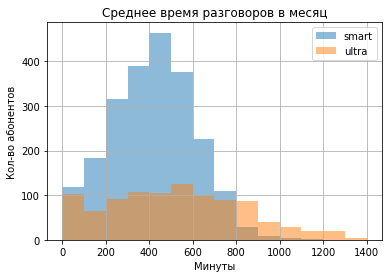

In [24]:
# гистограмма по среднему времени разгова в месяц
plt.hist(smart.month_calls_duration, alpha=0.5, bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400])
plt.hist(ultra.month_calls_duration, alpha=0.5, bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400])
plt.legend(['smart', 'ultra'])
plt.title('Среднее время разговоров в месяц')
plt.grid(True)
plt.xlabel('Минуты')
plt.ylabel('Кол-во абонентов')
plt.show()

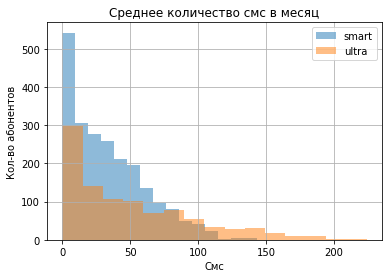

In [25]:
# гистограмма по среднему колличеству смс в месяц
plt.hist(smart.sms_month, alpha=0.5, bins=15)
plt.hist(ultra.sms_month, alpha=0.5, bins=15)
plt.legend(['smart', 'ultra'])
plt.title('Среднее количество смс в месяц')
plt.grid(True)
plt.xlabel('Смс')
plt.ylabel('Кол-во абонентов')
plt.show()

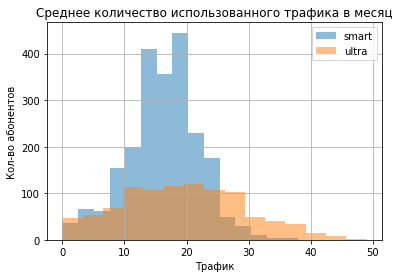

In [26]:
# гистограмма по среднему количеству использованного трафиа в месяц
plt.hist(smart.internet_month, alpha=0.5, bins=15)
plt.hist(ultra.internet_month, alpha=0.5, bins=15)
plt.legend(['smart', 'ultra'])
plt.title('Среднее количество использованного трафика в месяц')
plt.grid(True)
plt.xlabel('Трафик')
plt.ylabel('Кол-во абонентов')
plt.show()

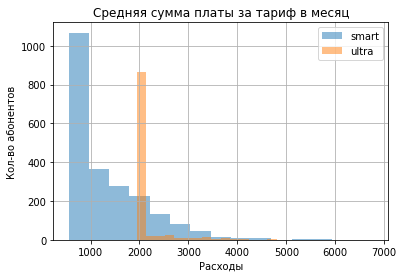

In [27]:
# гистограмма по средней сумме платы за тариф в месяц
plt.hist(smart.revenue, alpha=0.5, bins=15)
plt.hist(ultra.revenue, alpha=0.5, bins=15)
plt.legend(['smart', 'ultra'])
plt.title('Средняя сумма платы за тариф в месяц')
plt.grid(True)
plt.xlabel('Расходы')
plt.ylabel('Кол-во абонентов')
plt.show()

#### Вывод
    Пользователи тарифа ultra, в отличии от пользователей smart, редко расходуют сверх тарифа. Сообщения не пользуются большой популярностью в обоих тарифах. Пользователи тарифа ultra используют больше минут и интернета чем smart пользователи, при этом вторым приходится часто доплачивать за доп услуги тарифа. Стабильная выручка идет от тарифа Ultra.

## Проверка гипотез 

   1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

   2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### 1 гипотеза
H0 = средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются

H1 = средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [28]:
# делаем срезы по таблице в зависимости от тарифа
ultra = df[df['tariff'] == 'ultra']
smart = df[df['tariff'] == 'smart']

#возьмем из этих таблицы только столбец cash
ultra = ultra['revenue']
smart = smart['revenue']

# уровень статистической значимости будет равен 5%
alpha = 0.05 
# для проверки гипотез выбран t-test, так как генеральные совокупности не зависят друг от друга

results = st.ttest_ind(ultra, smart, equal_var=False) # параметр equal_var=False, т.к. дисперсия сильно различается
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Вывод: верна гипотеза H1: выручка пользователей тарифов "смарт" и "ультра" различается.

### 2 гипотеза
Н0: выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
    
H1: выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [29]:
# делаем срезы по таблице в зависимости от региона
moscow = df.query('city == "Москва"')
NOT_moscow = df.query('city != "Москва"')
#возьмем из этих таблицы только столбец cash
moscow = moscow['revenue']
NOT_moscow = NOT_moscow['revenue']

# уровень статистической значимости будет равен 5%
alpha = 0.05
# для проверки гипотез выбран t-test, так как генеральные совокупности не зависят друг от друга
results = st.ttest_ind(moscow, NOT_moscow, equal_var=False) # параметр equal_var=False, т.к. дисперсия сильно различается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Вывод: верна гипотеза Н0: выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

## Вывод

Завершив исследования, можно сделать следущие выводы:

- Пользвателям тарифа "смарт", в отличии от "ультра" чаще приходится покупать дополнительные услуги, т к "пакета"не хватает

- Стандартное отклонение по тарифу smart больше, чем по тарифу ultra.

- Средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

- Средняя выручка пользователей из Москвы почти не разлчается выручке пользователей из других регионов


## Какой тариф выбрать?
- С точки зрения оператора, выгодней чтобы люди пользвались тарифом ultra, т к с этого тарифа идет стабильная выручка. Хотя пользователям тарифа smart и приходится иногда брать услуги сверх "пакета", эта выручка очень нестабильна
- Для пользователя также выгодней тариф ultra. Хотя этот "пакет услуг" дороже, чем в тарифе smart, на графках нашего исследования видно, что пользователи smart часто берут доп.услуги, от чего ежемесячная плата становится больше. Около 70% людей, рассчитывают на то, что "пакета" smart им будет достаточно.